<a href="https://colab.research.google.com/github/as2092/Sentiment-Analysis/blob/master/SentimentAnalysis_EDA_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Sentiment Analysis?
Sentiment Analysis is one of the problems of NLP where models can detect opinion out of text. The text may be tweets about a business, product reviews by various users etc. and the opinion could be positive, negative or neutral.
<br>
# How does it work?
For automated sentiment analysis, we make use of deep learning/machine learning models wherein this problem is treated as a classification problem i.e. classify a piece of text as negative, positive or neutral<br>
As a supervised problem , this would involve a training phase and then the prediction phase: <br>
For training, the model is fed with various samples. Each sample has a text and its label. The text is converted to a feature vector before being fed to the model. The training flow is as shown below<br>
<br>
Text--> Features &  Label--> MODEL <br>
<br>
Once the model is trained , it can be used to predict the sentiment of a text.<br>
<br>
Text--> Features--> TRAINED MODEL --> Output(Sentiment)<br>
<br>
# What is the feature vector?
As a computational model can understand only numbers, it is required to convert the text to numbers. The classical approaches used Bag or words or bag of n-grams as features. Newer feature extraction techniques include word vectors/ word embeddings where words that are similar to each other lie closer on a vector space i.e. each word is converted to n-dimensional vector. This feature vector is fed to the model, as input. The word embeddings can be trained from scratch or there are pre-trained word embeddings e.g. Glove, word2vec which can be directly used to convert the words to feature vectors.<br>
<br>
# Our Approach
In this notebook, I'll create two RNN(LSTM) based models for classification of tweets as positive, negative or neutral. For model 1 , the word ebeddings would be trained from scratch whereas for model 2 pre-trained embeddings(Glove) are used.<br>
<br>
The dataset used is US Airlines Twitter dataset available on kaggle.   




# Getting the data

In [0]:
!mkdir -p ~/.kaggle

In [0]:
!mv kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 538kB/s 
     |████████████████████████████████| 5.3MB 1.1MB/s 
     |████████████████████████████████| 112kB 51.8MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 112kB 44.6MB/s 


In [0]:
!kaggle datasets list -s twitter-airline-sentiment

In [6]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 84.2MB/s]


In [7]:
!unzip twitter-airline-sentiment.zip

Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [0]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

In [0]:
# As we want text and its label as our data,, we can drop rest of the columns
df = pd.read_csv("Tweets.csv", usecols=['text', 'airline_sentiment'])

In [10]:
df=df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


In [11]:
df.shape

(14640, 2)

In [12]:
df.text[1:4]

1    @VirginAmerica plus you've added commercials to the experience... tacky.                                                      
2    @VirginAmerica I didn't today... Must mean I need to take another trip!                                                       
3    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
Name: text, dtype: object

In [0]:
import matplotlib.pyplot as plt


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


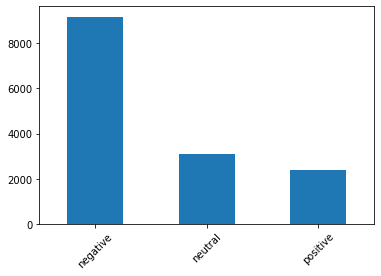

In [14]:
sentiment_count = df['airline_sentiment'].sort_index().value_counts()
print (sentiment_count)
sentiment_count.plot(kind='bar',rot=45)
plt.show()

As can be seen by the no. of tweets for each label, the dataset is more skewed towards negative category

# Spacy
Its modern and fast nlp library

In [0]:
!pip install -U spacy

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.2.4)


In [0]:
#download the language model
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:

# load the model and create an object
import spacy

nlp = spacy.load('en_core_web_sm')


# Data Preparation





Splitting the data into train, test and validation sets

In [0]:
import os
from sklearn.model_selection import train_test_split

In [0]:
df_train, df_split = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

In [0]:
df_val, df_test = train_test_split(df_split, test_size=0.5, random_state=42, shuffle=True)

In [0]:
os.mkdir('data')

In [0]:
df_train.to_csv('data/train.csv', index=False)
df_val.to_csv('data/val.csv', index=False)
df_test.to_csv('data/test.csv', index=False)

For futher implememtations I'll be using pytorch

In [0]:
import torch 
from torchtext import data

In [0]:
# set the seed and define the field
SEED = 2092

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [0]:
# creating training, validation and test set
train_data, val_data, test_data = data.TabularDataset.splits(path='data/',
                                                            train='train.csv',
                                                            validation='val.csv',
                                                            test='test.csv',
                                                            format='csv',
                                                            skip_header=True,
                                                            fields=[('text', TEXT), ('airline_sentiment', LABEL)])

In [0]:
type(train_data.examples)

list

In [0]:
print(len(train_data), len(test_data), len(val_data))

9808 2416 2416


In [0]:
print(vars(train_data.examples[0])) # tokenized example using spacy tokenizer

{'text': ['@JetBlue', 'of', 'course', 'I', 'am!!', '✈', '️'], 'airline_sentiment': 'neutral'}


As our models can understand only numbers, next task is to create a vocab and convert words to word embeddings. Words not in vocab are replaced by \<unk\>.We can train embeddings from scratch while training the model or we can use any pre-trained embeddings which would already have words with similar semantic meaning close together in the vector space. e.g. Glove, word2vec<br>


In [0]:
# use this for custom embeddings
MAX_VOCAB_SIZE = 15000

TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)


In [0]:
print(len(TEXT.vocab), len(LABEL.vocab)) #its 15002 bcause of <unk> and <pad>

15002 3


Padding is done so that all the sentences that are to be sent in a batch as input to the model are of same length

In [0]:
print(TEXT.vocab.itos[:20])

['<unk>', '<pad>', '.', 'to', 'I', 'the', '!', '?', 'a', ',', 'for', 'you', 'on', '@united', 'and', '#', 'flight', 'my', '@AmericanAir', '@USAirways']


In [0]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fb8aba12d08>, {'negative': 0, 'neutral': 1, 'positive': 2})


# Building Models


1.   Bi-directional LSTM with custom embedding
2.   Bi-directional LSTM with pre-trained embedding(Glove)
3.   Training the previous model with cleaned data


# Bi-directional LSTM with custom embedding

Next step is creating the iterators. We loop over these iterators during training/evaluation and these return batch of examples(padded and converted to tensors). BucketIterator is the one<br>
In order to place the returned tensors onto the GPU, we use torch.device and then pass this to the iterator

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

In [0]:
import torch.nn as nn

# creating the model class
class BiLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    self.bilstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
    self.fc = nn.Linear(hidden_dim * 2, output_dim)
      
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, text_lengths):
        
      #text = [sent len, batch size]
      
      embedded = self.dropout(self.embedding(text))
      
      #embedded = [sent len, batch size, emb dim]
      
      #pack sequence
      packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
      
      packed_output, (hidden, cell) = self.bilstm(packed_embedded)
      
      #unpack sequence
      output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

      #output = [sent len, batch size, hid dim * num directions]
      #output over padding tokens are zero tensors
      
      #hidden = [num layers * num directions, batch size, hid dim]
      #cell = [num layers * num directions, batch size, hid dim]
      
      #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
      #and apply dropout
      
      hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
              
      #hidden = [batch size, hid dim * num directions]
          
      return self.fc(hidden)

Create an instance of BiLstm class and load the parameters

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiLSTM(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [0]:
# create an optimizer
import torch.optim as optim

optimizer = optim.Adam(model.parameters())  # this alogo would update the model's parameters, pytorch sets the leaning rate itself

In [0]:
# defining the loss function is known as criterion
criterion = nn.CrossEntropyLoss()

# place the model and criterion to the GPU
model = model.to(device)
criterion = criterion.to(device)

# Training the model

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy for each batch
    """

    _, preds = torch.max(preds, 1)
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # model in training mode
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        # print(predictions.shape)
        # print(predictions)
        
        loss = criterion(predictions, batch.airline_sentiment.long())
        
        acc = binary_accuracy(predictions, batch.airline_sentiment.long())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            # print(predictions.shape)
            
            loss = criterion(predictions, batch.airline_sentiment.long())
            
            acc = binary_accuracy(predictions, batch.airline_sentiment.long())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [0]:
# model training
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.352 | Train Acc: 86.07%
	 Val. Loss: 0.615 |  Val. Acc: 78.76%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.340 | Train Acc: 86.85%
	 Val. Loss: 0.639 |  Val. Acc: 79.74%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.310 | Train Acc: 88.12%
	 Val. Loss: 0.674 |  Val. Acc: 79.28%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.294 | Train Acc: 88.73%
	 Val. Loss: 0.710 |  Val. Acc: 79.67%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.268 | Train Acc: 89.92%
	 Val. Loss: 0.693 |  Val. Acc: 78.96%


# Bi-directional LSTM with pre-trained embedding (Glove)

In [0]:
# use this for pre-trained embeddings
MAX_VOCAB_SIZE = 15000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:32, 2.20MB/s]                          
100%|█████████▉| 398733/400000 [00:15<00:00, 25432.34it/s]

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

In [0]:
import torch.nn as nn

class BiLSTM1(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
    self.bilstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
    self.fc = nn.Linear(hidden_dim * 2, output_dim)
      
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, text_lengths):
        
      #text = [sent len, batch size]
      
      embedded = self.dropout(self.embedding(text))
      
      #embedded = [sent len, batch size, emb dim]
      
      #pack sequence
      packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
      
      packed_output, (hidden, cell) = self.bilstm(packed_embedded)
      
      #unpack sequence
      output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

      #output = [sent len, batch size, hid dim * num directions]
      #output over padding tokens are zero tensors
      
      #hidden = [num layers * num directions, batch size, hid dim]
      #cell = [num layers * num directions, batch size, hid dim]
      
      #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
      #and apply dropout
      
      hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
              
      #hidden = [batch size, hid dim * num directions]
          
      return self.fc(hidden)


Next we create an instance for BiLSTM class and load the parameters 

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiLSTM1(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [0]:
pretrained_embeddings = TEXT.vocab.vectors

#embeddings must be of shape [vocab, embedding_dim]
print(pretrained_embeddings.shape)
# replace the initial weight with pre-tained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([15002, 100])


tensor([[-0.4472,  0.8308, -0.2964,  ..., -0.2595,  0.0280, -1.7661],
        [ 0.0085, -1.2282,  0.7894,  ..., -0.3807, -0.7760, -0.7863],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.6482,  0.3508, -0.0585,  ...,  0.4474,  0.6879,  0.1730],
        [ 0.0040,  0.4810,  1.0443,  ..., -0.3594,  0.0817,  0.8400],
        [-0.5422, -0.3478,  0.2168,  ...,  0.3376, -0.0022, -0.0664]])

In [0]:
# initialize <pad> and <unk> weights to zeros
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.6482,  0.3508, -0.0585,  ...,  0.4474,  0.6879,  0.1730],
        [ 0.0040,  0.4810,  1.0443,  ..., -0.3594,  0.0817,  0.8400],
        [-0.5422, -0.3478,  0.2168,  ...,  0.3376, -0.0022, -0.0664]])


In [0]:
# create an optimizer
import torch.optim as optim

optimizer = optim.Adam(model.parameters())  # this alogo would update the model's parameters, pytorch sets the leaning rate itself

In [0]:
# defining the loss function is known as criterion
criterion = nn.CrossEntropyLoss()

# place the model and criterion to the GPU
model = model.to(device)
criterion = criterion.to(device)

# Training the Model

In [0]:
# model training
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.805 | Train Acc: 66.02%
	 Val. Loss: 0.669 |  Val. Acc: 72.83%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.658 | Train Acc: 72.50%
	 Val. Loss: 0.618 |  Val. Acc: 75.60%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.586 | Train Acc: 76.62%
	 Val. Loss: 0.558 |  Val. Acc: 78.14%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.532 | Train Acc: 78.77%
	 Val. Loss: 0.533 |  Val. Acc: 79.00%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.484 | Train Acc: 80.49%
	 Val. Loss: 0.539 |  Val. Acc: 79.88%


Lets try Model 2(the one using pre-trained embeddings) with cleaned data i.e. removing hashtags, twitter handles and some numeric characters from the dataset. The model training and evealuation flow would be the same as previous models.

# Cleaning the data

In [0]:
import re

def pre_processing(text):
  """
  remove hashtags, twitter handles and some numeric characters from the dataset
  """
  # lowercase text
  text = text.lower()
  # remove twitter handles
  text = re.sub("@[^\s]+", "", text)
  # remove hashtags by the words in it
  text = re.sub("#([^\s]+)", r'\1', text)
  #remove urls
  text = re.sub("((www\.[^s]+)|(https?://[^s]+))", "", text)
  # remove any char other than alphabets
  text = re.sub("[^a-z\s]+", " ", text) # need to take care whether to remove this or not
  # remove whitespace
  text = text.strip()

  return text

In [0]:
# apply function on the dataframe for cleaning
df_train = df_train.applymap(pre_processing)
df_val = df_val.applymap(pre_processing)
df_test = df_test.applymap(pre_processing)

In [0]:
os.mkdir('data1')

In [0]:
df_train.to_csv('data1/train.csv', index=False)
df_val.to_csv('data1/val.csv', index=False)
df_test.to_csv('data1/test.csv', index=False)

In [0]:
# creating training, validation and test set
train_data, val_data, test_data = data.TabularDataset.splits(path='data1/',
                                                            train='train.csv',
                                                            validation='val.csv',
                                                            test='test.csv',
                                                            format='csv',
                                                            skip_header=True,
                                                            fields=[('text', TEXT), ('airline_sentiment', LABEL)])

In [0]:
print(vars(train_data.examples[0]))

{'text': ['of', 'course', 'i', 'am'], 'airline_sentiment': 'neutral'}


In [0]:
# use this for pre-trained embeddings
MAX_VOCAB_SIZE = 15000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiLSTM1(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [0]:
pretrained_embeddings = TEXT.vocab.vectors

#embeddings must be of shape [vocab, embedding_dim]
print(pretrained_embeddings.shape)
# replace the initial weight with pre-tained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([9396, 100])


tensor([[-0.1958, -1.1607,  0.3943,  ...,  0.6818, -0.4271,  2.0687],
        [ 1.1998, -0.4473,  1.2064,  ...,  0.4942, -0.3781,  1.3651],
        [ 0.6647,  2.1960, -0.5188,  ..., -0.3910, -0.1504, -0.6958],
        ...,
        [-0.5556, -0.0176,  0.6531,  ...,  0.2495, -0.0756,  0.0662],
        [-0.6644, -0.3045,  0.6151,  ...,  0.1404,  0.5788, -0.0333],
        [-1.3948, -1.6095, -0.0666,  ..., -0.2980,  0.5114,  0.6250]])

In [0]:
# initialize <pad> and <unk> weights to zeros
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [0]:
optimizer = optim.Adam(model.parameters())  # this alogo would update the model's parameters, pytorch sets the leaning rate itself

# defining the loss function is known as criterion
criterion = nn.CrossEntropyLoss()

# place the model and criterion to the GPU
model = model.to(device)
criterion = criterion.to(device)

In [0]:
# model training
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.806 | Train Acc: 65.72%
	 Val. Loss: 0.616 |  Val. Acc: 75.32%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.632 | Train Acc: 74.10%
	 Val. Loss: 0.556 |  Val. Acc: 77.92%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.554 | Train Acc: 78.01%
	 Val. Loss: 0.506 |  Val. Acc: 80.56%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.497 | Train Acc: 80.49%
	 Val. Loss: 0.491 |  Val. Acc: 81.00%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.461 | Train Acc: 81.65%
	 Val. Loss: 0.507 |  Val. Acc: 81.55%


validation accuracy is more, if the model is trained on cleaned data.

Next we'll try ULMFit for sentiment analysis in other notebook